In [1]:
import os,sys,torch
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
from melanoma.data.dataset import SIIMDataset
from melanoma.config import TRAIN_CSV, IMAGE_DIR, TEST_CSV
dataset = SIIMDataset(IMAGE_DIR, TRAIN_CSV)
import albumentations as A

In [3]:
def medium_2(image_size=None, p=1.0):
    return A.Compose([
        # RandomCrop(input_size) / RandomResizedCrop (0.08, 1)
        A.HorizontalFlip(p=0.5), # vflip
        A.VerticalFlip(p=0.5), # hflip
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3),
        # shear 10,
        A.RandomBrightnessContrast(brightness_limit=0.125, contrast_limit=0.5, p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, p=0.2),
        A.Cutout(num_holes=2, max_h_size=16, max_w_size=16)
    ], p=p)


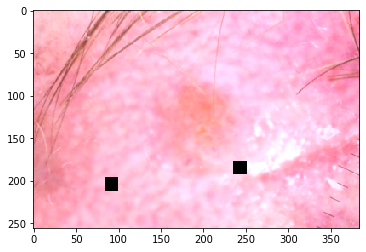

(256, 384, 3) uint8 /mnt/fastdata/kaggle/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011_small.jpg


In [4]:
elem = dataset[0]
img = cv2.cvtColor(elem['image'], cv2.COLOR_BGR2RGB)
#aug = strong_aug(p=1)
aug = medium_2()
#img = A.HorizontalFlip().apply(img)
new_img = aug(image=img)['image']
plt.imshow(new_img)
plt.show()
print(img.shape, img.dtype, elem['path'])

(256, 384, 3)
time 0.3731710910797119


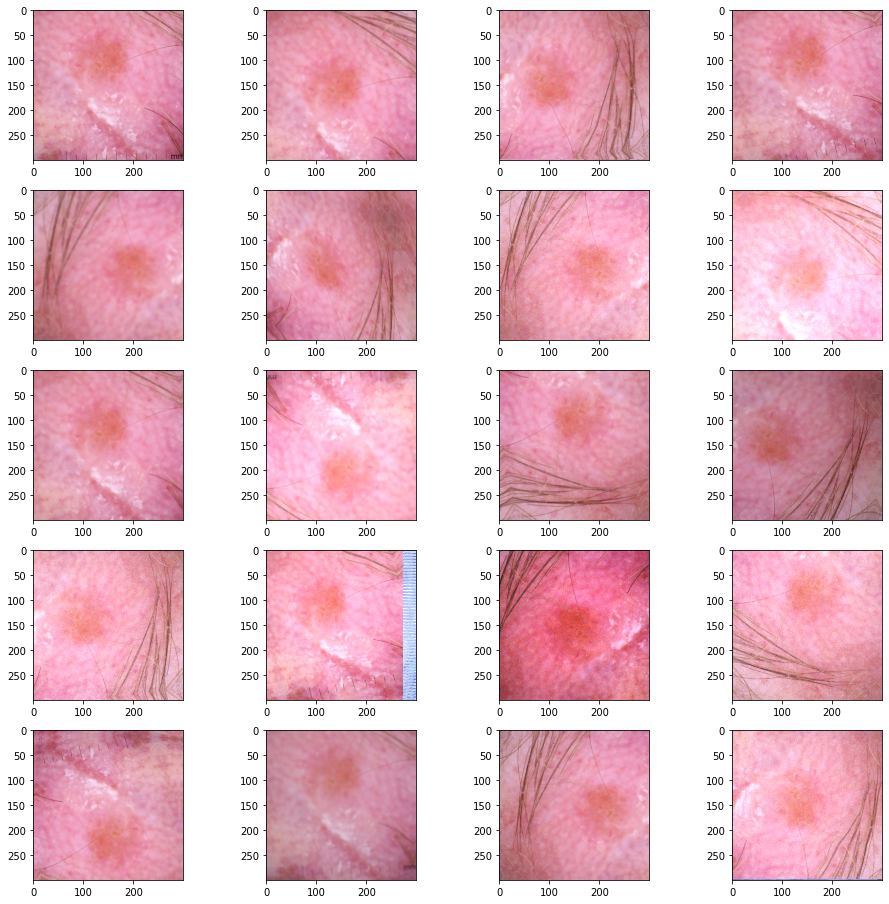

In [15]:
import time
from melanoma.data.transform import factory
elem = dataset[0]
img = cv2.cvtColor(elem['image'], cv2.COLOR_BGR2RGB)
print(img.shape)
aug = factory('heavy_1', 300, p=1.0, without_norm=True)[0]
#aug = strong_aug(p=1)

w, h = 40, 40
columns, rows = 4, 5
fig=plt.figure(figsize=(16, 16))
t1 = time.time()
new_images = [aug(image=img)['image'] for _ in range(columns*rows)]
print('time', time.time()-t1) # 14 m1, 3.9 m2, 36 h1 for 50x

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    new_img = new_images[i-1]
    #new_img = aug(img)
    plt.imshow(new_img.permute(1, 2, 0).numpy())
    #print(new_img.shape, np.max(new_img))
    #print(new_img.size(), torch.max(new_img))
plt.show()

In [6]:
print('Start')
from melanoma.data.utils import Datasets

ll = Datasets(IMAGE_DIR, TRAIN_CSV, TEST_CSV, transform_name='heavy_1',
            image_size=300)
tr = ll.train_dataset

for i, elem in enumerate(tr):
    if elem['image'] is None:
        print(elem)
    if i % 1000 == 0:
        print(i, len(tr))




2020-06-08 20:18:26 Length of datasets train/val/test=26320/6806/10982


Start
0 26320
1000 26320


KeyboardInterrupt: 